In [1]:
import cv2
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from skimage import io
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from google.colab import files
upload_image = files.upload()

Saving left_img.png to left_img.png
Saving right_img.png to right_img.png


In [2]:
left_img = cv2.imread("left_img.png", cv2.IMREAD_GRAYSCALE)
right_img = cv2.imread("right_img.png", cv2.IMREAD_GRAYSCALE)

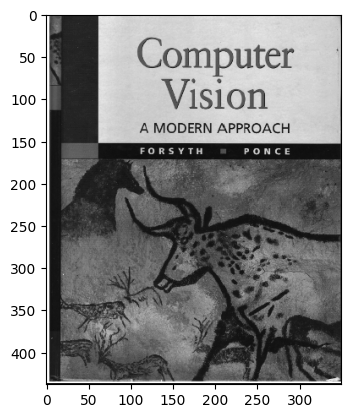

In [3]:
plt.imshow(left_img, cmap='gray');

In [4]:
left_img.shape[0]


438

In [5]:
left_img.shape[1]

350

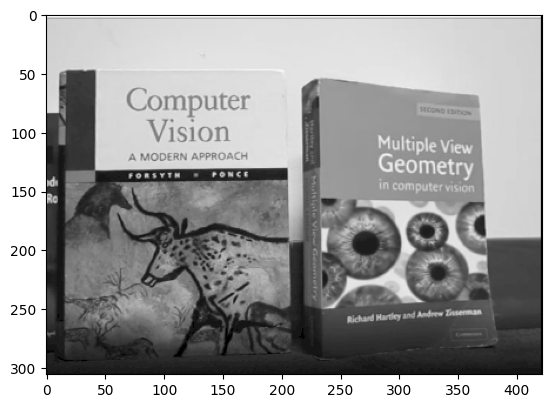

In [6]:
plt.imshow(right_img, cmap='gray');

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import numpy as np
import cv2

def loadVid(path):
	# Create a VideoCapture object and read from input file
	# If the input is the camera, pass 0 instead of the video file name
	cap = cv2.VideoCapture(path)

	# Check if camera opened successfully
	if (cap.isOpened()== False):
		print("Error opening video stream or file")

	i = 0
	# Read until video is completed
	while(cap.isOpened()):
		# Capture frame-by-frame
		i += 1
		ret, frame = cap.read()
		if ret == True:

			#Store the resulting frame
			if i == 1:
				frames = frame[np.newaxis, ...]
			else:
				frame = frame[np.newaxis, ...]
				frames = np.vstack([frames, frame])
				frames = np.squeeze(frames)

		else:
			break

	# When everything done, release the video capture object
	cap.release()

	return frames


In [9]:
frames_of_book_video = loadVid("/content/drive/MyDrive/Project1/book.mov")

In [10]:
frames_of_Kung_fu_Panda1 = loadVid("/content/drive/MyDrive/Project1/ar_source.mov")

In [11]:
frames_of_Kung_fu_Panda = []
for i in range(0,len(frames_of_Kung_fu_Panda1)):
  temp = frames_of_Kung_fu_Panda1[i]
  temp = temp[50:310,:]
  frames_of_Kung_fu_Panda.append(temp)

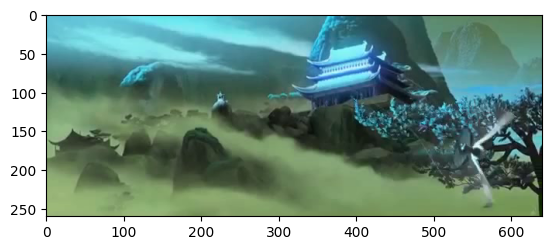

In [12]:
plt.imshow(frames_of_Kung_fu_Panda[0])

In [13]:
# Create SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors for both images
keypoints1, descriptors1 = sift.detectAndCompute(left_img, None)
keypoints2, descriptors2 = sift.detectAndCompute(right_img, None)

# Create a BFMatcher object
bf = cv2.BFMatcher()

# Match descriptors using KNN (k-nearest neighbors)
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

46


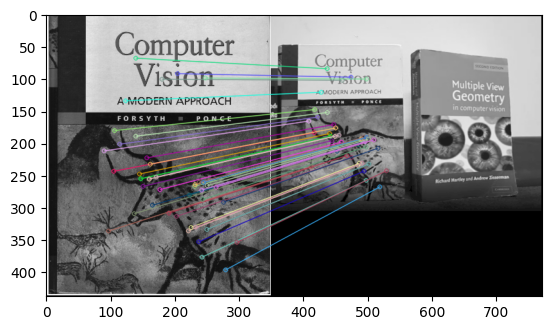

In [14]:
# Apply ratio test
good_matches = []
for m, n in matches:
  if (m.distance / n.distance) < 0.3:
    good_matches.append(m)
print(len(good_matches))
# Draw the matches
result_image = cv2.drawMatches(left_img, keypoints1, right_img, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the result
plt.imshow(result_image);

In [15]:
def make_A(x,y,x_dash,y_dash):
  A = []
  for i in range(len(x)):
    A.append([-x[i],-y[i],-1,0,0,0,x[i]*x_dash[i],y[i]*x_dash[i],x_dash[i]])
    A.append([0,0,0,-x[i],-y[i],-1,x[i]*y_dash[i],y[i]*y_dash[i],y_dash[i]])
  return np.array(A)

In [16]:
def calculate_H(A):
  U, S, Vt = np.linalg.svd(A)
  H = Vt[-1]
  H = np.reshape(H, (3, 3))
  H /= H[2, 2]
  return H

In [17]:
points1 = [keypoints1[m.queryIdx].pt for m in good_matches]
points2 = [keypoints2[m.trainIdx].pt for m in good_matches]

# Convert the points to integers
x, x_dash = [], []
y, y_dash = [], []
for x1, y1 in points2:
  x.append(int(x1))
  y.append(int(y1))

for x1, y1 in points1:
  x_dash.append(int(x1))
  y_dash.append(int(y1))

In [18]:
len(x), len(x_dash), len(y), len(y_dash)

(46, 46, 46, 46)

In [19]:
def calculate_coordinates(H, img):
  pixel_position = np.array([0, 0, 1])
  up_left = np.dot(H, pixel_position)
  up_left /= up_left[-1]

  pixel_position = np.array([img.shape[1], 0, 1])
  up_right = np.dot(H, pixel_position)
  up_right /= up_right[-1]

  pixel_position = np.array([0, img.shape[0], 1])
  down_left = np.dot(H, pixel_position)
  down_left /= down_left[-1]

  pixel_position = np.array([img.shape[1], img.shape[0], 1])
  down_right = np.dot(H, pixel_position)
  down_right /= down_right[-1]

  height = max(abs(down_left[1] - up_left[1]), abs(down_right[1] - up_right[1]))
  width  = max(abs(up_right[0] - up_left[0]), abs(down_right[0] - down_left[0]))

  return int(height), int(width)

In [20]:
def forward_warp(H, new_img, img, offset1=0, offset2=0):
  for j in range(img.shape[0]):
    for i in range(img.shape[1]):
      pixel_position = np.array([i, j, 1])
      new_position = np.dot(H, pixel_position)
      new_position /= new_position[-1]
      new_img[int(new_position[1])+offset1, int(new_position[0])+offset2, :] = img[j, i, :]
  return new_img

In [21]:
def single_inverse_warp(w, h, c, H_inv, img):
  pixel_position = np.array([w, h, 1])
  original_position = np.dot(H_inv, pixel_position)
  original_position /= original_position[-1]

  P = [[int(np.floor(original_position[0])), int(np.floor(original_position[1]))],
      [int(np.ceil(original_position[0])), int(np.floor(original_position[1]))],
      [int(np.floor(original_position[0])), int(np.ceil(original_position[1]))],
      [int(np.ceil(original_position[0])), int(np.ceil(original_position[1]))]]

  x, y = original_position[0]-P[0][0], original_position[1]-P[0][1]
  W = [(1-x)*(1-y), x*(1-y), (1-x)*y, x*y]

  pixel_value = 0
  for (p, w) in zip(P, W):
    if 0 <= p[0] < img.shape[1] and 0 <= p[1] < img.shape[0]:
      pixel_value += img[p[1], p[0], c] * w

  return pixel_value

In [22]:
def inverse_warp(height, width, H, offset1, offset2, stitched_image, img):
  H_inv = np.linalg.inv(H)
  for i in range(height):
    for j in range(width):
      for k in range(3):
        if stitched_image[i, j, k] == 0:
          pixel_value = single_inverse_warp(j-offset2, i-offset1, k, H_inv, img)
          stitched_image[i, j, k] = int(pixel_value)
  return stitched_image

In [23]:
def overlay(stitched_image, img, offset1=0, offset2=0):
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        # if stitched_image[i, j].any() == 0:
          stitched_image[i+offset1, j+offset2, :] = img[i, j, :]
  return stitched_image

## Projecting left image on right

In [24]:
left_img = cv2.imread("left_img.png", cv2.COLOR_BGR2RGB)
right_img = cv2.imread("right_img.png", cv2.COLOR_BGR2RGB)

A = make_A(x, y, x_dash, y_dash)
U, S, Vt = np.linalg.svd(A)
H_right = Vt[-1]
H_right = np.reshape(H_right, (3, 3))
H_right /= H_right[2, 2]

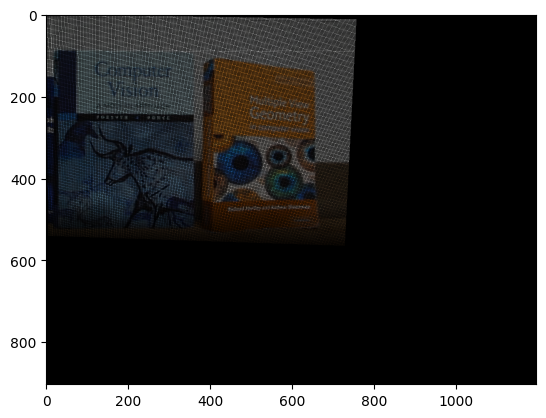

In [25]:
height, width = calculate_coordinates(H_right, right_img)
stitched_height = int(height) + left_img.shape[1]
stitched_width  = int(width)  + left_img.shape[0]

# offset2, offset1 = 0, 0
origin1 = np.dot(H_right, [0, 0, 1])
origin1 /= origin1[-1]
origin2 = np.dot(H_right, [0, right_img.shape[0], 1])
origin2 /= origin2[-1]
origin = [min(origin1[0], origin2[0]), origin1[1]]
offset2, offset1 = int(origin[0]*-1), int(origin[1]*-1)

stitched_image = np.zeros((stitched_height, stitched_width, 3), dtype=np.uint8)
stitched_image = forward_warp(H_right, stitched_image, right_img, offset1, offset2)

plt.imshow(stitched_image);

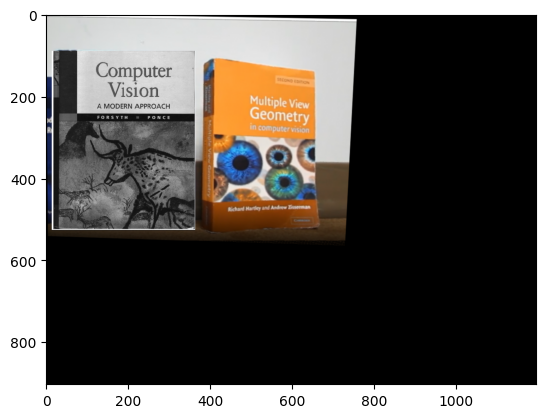

In [26]:
stitched_image = inverse_warp(height, width, H_right, offset1, offset2, stitched_image, right_img)
stitched_image = overlay(stitched_image, left_img, offset1, offset2)

plt.imshow(stitched_image);

In [27]:
def do_all_the_stuff(left_image, right_image, real_left_image):

    temp1 = left_image
    temp2 = right_image
    # Load images
    left_img = cv2.cvtColor(left_image, cv2.COLOR_BGR2GRAY)
    right_img = cv2.cvtColor(right_image, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(left_img, None)
    keypoints2, descriptors2 = sift.detectAndCompute(right_img, None)
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if (m.distance / n.distance) < 0.3:
            good_matches.append(m)
    result_image = cv2.drawMatches(left_img, keypoints1, right_img, keypoints2, good_matches, None,
                                   flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


    points1 = [keypoints1[m.queryIdx].pt for m in good_matches]
    points2 = [keypoints2[m.trainIdx].pt for m in good_matches]

    # Convert the points to integers
    x, x_dash = [], []
    y, y_dash = [], []
    for x1, y1 in points2:
        x.append(int(x1))
        y.append(int(y1))

    for x1, y1 in points1:
        x_dash.append(int(x1))
        y_dash.append(int(y1))

    left_img = cv2.cvtColor(temp1, cv2.COLOR_BGR2RGB)
    right_img = cv2.cvtColor(temp2, cv2.COLOR_BGR2RGB)

    A = make_A(x, y, x_dash, y_dash)
    U, S, Vt = np.linalg.svd(A)
    H_right = Vt[-1]
    H_right = np.reshape(H_right, (3, 3))
    H_right /= H_right[2, 2]


    height, width = calculate_coordinates(H_right, right_img)
    stitched_height = int(height) + left_img.shape[1]
    stitched_width  = int(width)  + left_img.shape[0]

    # offset2, offset1 = 0, 0
    origin1 = np.dot(H_right, [0, 0, 1])
    origin1 /= origin1[-1]
    origin2 = np.dot(H_right, [0, right_img.shape[0], 1])
    origin2 /= origin2[-1]
    origin = [min(origin1[0], origin2[0]), origin1[1]]
    offset2, offset1 = int(origin[0]*-1), int(origin[1]*-1)

    stitched_image = np.zeros((stitched_height, stitched_width, 3), dtype=np.uint8)
    stitched_image = forward_warp(H_right, stitched_image, right_img, offset1, offset2)


    stitched_image = inverse_warp(height, width, H_right, offset1, offset2, stitched_image, right_img)
    stitched_image = overlay(stitched_image, real_left_image, offset1, offset2)
    return stitched_image

In [28]:
def crop_and_pad_image(image, x1, x2, y1, y2, target_height):
    height, width, channels = image.shape
    x1 = max(0, x1)
    x2 = min(width, x2)
    y1 = max(0, y1)
    y2 = min(height, y2)

    crop_width = x2 - x1
    crop_height = y2 - y1

    cropped_padded_image = np.zeros((target_height, crop_width, channels), dtype=np.uint8)

    paste_x1 = max(0, -x1)
    paste_x2 = min(crop_width, width - x1)
    paste_y1 = max(0, -y1)
    paste_y2 = min(crop_height, height - y1)
    cropped_padded_image[paste_y1:paste_y2, paste_x1:paste_x2, :] = image[y1 + paste_y1:y1 + paste_y2, x1 + paste_x1:x1 + paste_x2, :]
    remaining_height = target_height - crop_height
    cropped_padded_image[paste_y2:paste_y2 + remaining_height, :, :] = 0

    return cropped_padded_image

In [29]:
def crop_and_resize_image(image, x1, x2, y1, y2, target_width, target_height):
    height, width, channels = image.shape
    x1 = max(0, x1)
    x2 = min(width, x2)
    y1 = max(0, y1)
    y2 = min(height, y2)

    crop_width = x2 - x1
    crop_height = y2 - y1

    # Crop the region of interest
    cropped_image = image[y1:y2, x1:x2, :]

    # Resize the cropped region to the target dimensions
    resized_image = cv2.resize(cropped_image, (target_width, target_height))

    return resized_image

In [30]:
target_width = left_img.shape[1]
target_height = left_img.shape[0]
croped_panda_frames = []
for i in range(0,len(frames_of_Kung_fu_Panda)):
  croped_panda_frames.append(crop_and_resize_image(frames_of_Kung_fu_Panda[i], 145, 145 + left_img.shape[1], 0, left_img.shape[0], target_width, target_height))

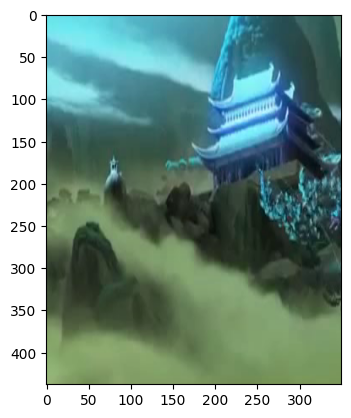

In [31]:
plt.imshow(croped_panda_frames[0])

In [32]:
print(len(frames_of_book_video))
print(len(croped_panda_frames))

while len(frames_of_book_video) > len(croped_panda_frames):
    frames_of_book_video = np.delete(frames_of_book_video, -1, axis=0)

print(len(frames_of_book_video))
print(len(croped_panda_frames))

641
511
511
511


In [33]:
stitched_frame = do_all_the_stuff(left_img, frames_of_book_video[0], croped_panda_frames[0])

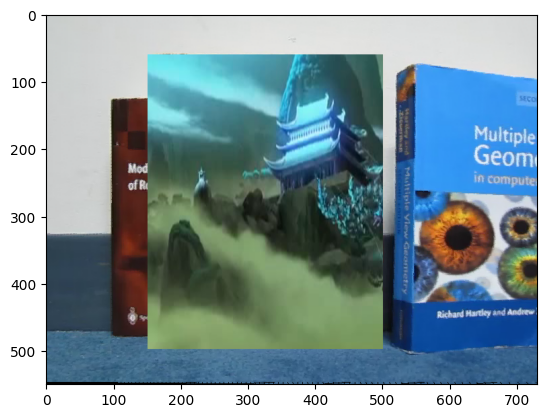

In [34]:
plt.imshow(stitched_frame[50:600, :730])

In [35]:
import os
output_directory = '/content/drive/MyDrive/Project1/stitched_frames'

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

for i in range(0, len(frames_of_book_video)):
      stitched_frame = do_all_the_stuff(left_img, frames_of_book_video[i], croped_panda_frames[i])
      #stitched_frame = stitched_frame[50:600, :730]
      filename = os.path.join(output_directory, f"stitched_frame_{i}.png")
      cv2.imwrite(filename, cv2.cvtColor(stitched_frame, cv2.COLOR_BGR2RGB))


print("Frames saved to:", output_directory)


Frames saved to: /content/drive/MyDrive/Project1/stitched_frames


In [53]:
from moviepy.editor import ImageSequenceClip, AudioFileClip
from PIL import Image
import numpy as np
import os

image_directory = '/content/drive/MyDrive/Project1/stitched_frames'

image_files = sorted([f for f in os.listdir(image_directory) if f.startswith('stitched_frame_') and f.endswith(('.png', '.jpg', '.jpeg'))], key=lambda x: int(''.join(filter(str.isdigit, x))))

desired_size = (500, 500)

image_clips = []
for img in image_files:
    image_path = os.path.join(image_directory, img)
    image = Image.open(image_path)
    resized_image = image.resize(desired_size)
    image_array = np.array(resized_image)
    image_array = image_array[50:600, :730]
    image_clips.append(image_array)

video_clip = ImageSequenceClip(image_clips, fps=30)

audio_file_path = '/content/drive/MyDrive/Project1/ar_source.mp3'
audio_clip = AudioFileClip(audio_file_path)
video_clip = video_clip.set_audio(audio_clip)

video_clip = video_clip.crop(y1=0, y2=300, x1=0, x2=320)

output_path = '/content/drive/MyDrive/Project1/output_video.mp4'
video_clip.write_videofile(output_path, codec='libx264', audio_codec='aac', temp_audiofile='temp-audio.m4a', remove_temp=True)

output_path


Moviepy - Building video /content/drive/MyDrive/Project1/output_video.mp4.
MoviePy - Writing audio in temp-audio.m4a


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/Project1/output_video.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/Project1/output_video.mp4


'/content/drive/MyDrive/Project1/output_video.mp4'